# Notebook 2: EDA y Preparación (Universo Dinámico)

## Objetivo

Preparar un dataset de precios y retornos para backtesting de momentum con **universo dinámico**: nuevos activos pueden comenzar a cotizar después del inicio del backtest y volverse elegibles en rebalanceos futuros cuando acumulen histórico suficiente.

## Idea clave

- No se elimina un ticker solo por no existir desde `history_start`.
- La pertenencia al universo de inversión se define por **elegibilidad por fecha de rebalanceo**.

## Librerías permitidas

Solo se usan: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scipy`, `pyarrow`.

## Configuración y carga de datos

Se cargan los datos desde Parquet y se construyen `DataFrame` wide para precios `close` y `open`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

BACKTEST_START_DATE = '2015-01-01'
MIN_MONTHS_HISTORY = 13
FFILL_GAP_LIMIT_DAYS = 5

DATA_RAW_DIR = '../datos/raw'
DATA_PROCESSED_DIR = '../datos/processed'

TICKERS_PARQUET = f'{DATA_RAW_DIR}/tickers_data.parquet'
SPY_PARQUET = f'{DATA_RAW_DIR}/spy_data.parquet'

print(f'Configuración: BACKTEST_START_DATE={BACKTEST_START_DATE}, '
      f'MIN_MONTHS_HISTORY={MIN_MONTHS_HISTORY}, '
      f'FFILL_GAP_LIMIT_DAYS={FFILL_GAP_LIMIT_DAYS}')

tickers_df = pd.read_parquet(TICKERS_PARQUET)
if not isinstance(tickers_df.index, pd.DatetimeIndex):
    if 'date' in tickers_df.columns:
        tickers_df['date'] = pd.to_datetime(tickers_df['date'])
        tickers_df = tickers_df.set_index('date')
    else:
        raise ValueError("No se encuentra índice datetime ni columna 'date'.")
tickers_df = tickers_df.sort_index()

required_cols = {'symbol', 'close', 'open'}
if required_cols - set(tickers_df.columns):
    raise ValueError(f'Faltan columnas: {sorted(required_cols - set(tickers_df.columns))}')

spy_df = pd.read_parquet(SPY_PARQUET)
if not isinstance(spy_df.index, pd.DatetimeIndex) and 'date' in spy_df.columns:
    spy_df['date'] = pd.to_datetime(spy_df['date'])
    spy_df = spy_df.set_index('date').sort_index()

# Normalizar timezone: convertir a naive si tiene timezone
if spy_df.index.tz is not None:
    spy_df.index = spy_df.index.tz_localize(None)

print(f'Datos cargados: tickers {tickers_df.shape}, spy {spy_df.shape}')

prices_close_wide = tickers_df.pivot_table(index=tickers_df.index,
                                          columns='symbol',
                                          values='close').sort_index()
prices_open_wide = tickers_df.pivot_table(index=tickers_df.index,
                                          columns='symbol',
                                          values='open').sort_index()

assert prices_open_wide.shape == prices_close_wide.shape
assert (prices_open_wide.index == prices_close_wide.index).all()
assert (prices_open_wide.columns == prices_close_wide.columns).all()

print(f'Precios wide: {prices_close_wide.shape}, '
      f'{prices_close_wide.index.min().date()} a {prices_close_wide.index.max().date()}')

prices_wide = prices_close_wide  # Compatibilidad

Configuración: BACKTEST_START_DATE=2015-01-01, MIN_MONTHS_HISTORY=13, FFILL_GAP_LIMIT_DAYS=5
Datos cargados: tickers (7250110, 13), spy (2798, 13)
Precios wide: (9087, 1289), 1990-01-02 a 2026-01-30


## Fase 1: Fechas y diagnóstico de entradas tardías

Se calculan fechas críticas y se diagnostican `first_date` por ticker para entender entradas tardías (sin usar esto para eliminar activos).

Fechas críticas: data_start=1990-01-02, history_start=2013-12-01, backtest_start=2015-01-01, data_end=2026-01-30
Tickers con datos: 1289


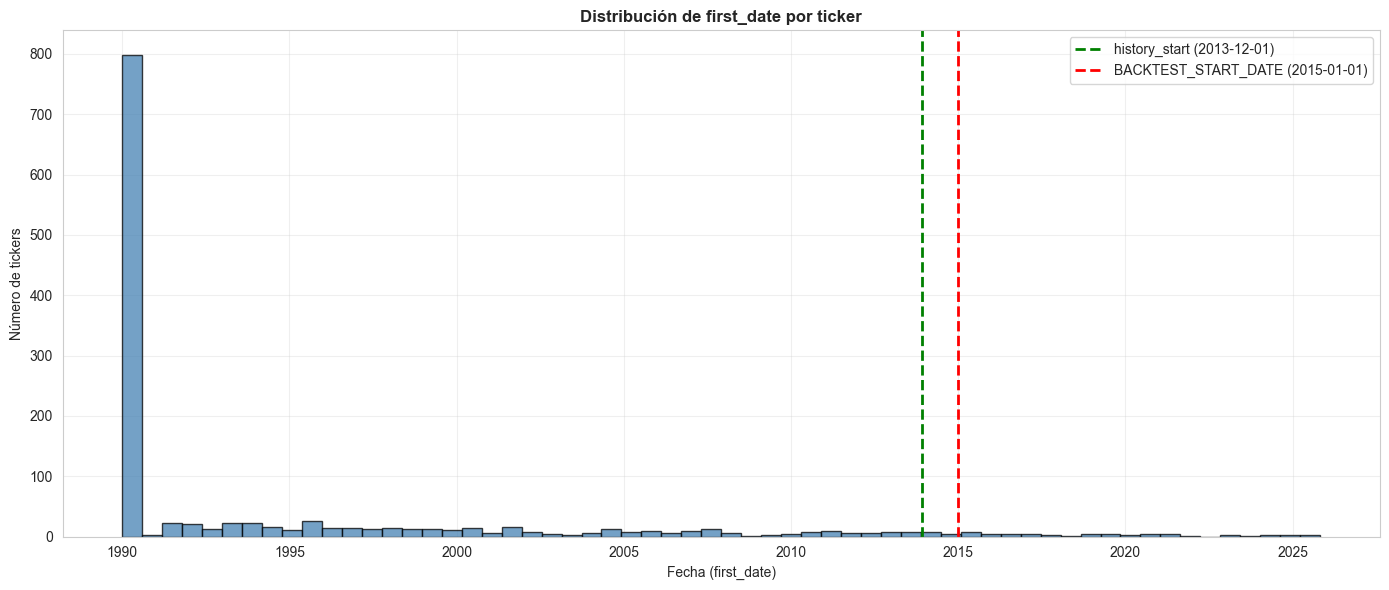

In [ ]:
import matplotlib.dates as mdates

backtest_start = pd.to_datetime(BACKTEST_START_DATE)
if backtest_start.tz is not None:
    backtest_start = backtest_start.tz_localize(None)
history_start = backtest_start - pd.DateOffset(months=MIN_MONTHS_HISTORY)
data_start = prices_wide.index.min()
data_end = prices_wide.index.max()

print(f'Fechas críticas: data_start={data_start.date()}, '
      f'history_start={history_start.date()}, '
      f'backtest_start={backtest_start.date()}, data_end={data_end.date()}')

first_date = prices_wide.apply(pd.Series.first_valid_index)
last_date = prices_wide.apply(pd.Series.last_valid_index)
dates_df = pd.DataFrame({'first_date': first_date, 'last_date': last_date})

print(f'Tickers con datos: {dates_df["first_date"].notna().sum()}')

valid_first = dates_df['first_date'].dropna()
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(valid_first, bins=60, color='steelblue', alpha=0.75, edgecolor='black')
ax.axvline(history_start, color='green', linestyle='--', linewidth=2,
           label=f'history_start ({history_start.date()})')
ax.axvline(backtest_start, color='red', linestyle='--', linewidth=2,
           label=f'BACKTEST_START_DATE ({backtest_start.date()})')
ax.set_title('Distribución de first_date por ticker', fontweight='bold')
ax.set_xlabel('Fecha (first_date)')
ax.set_ylabel('Número de tickers')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()



## Fase 2: Calidad de datos sin penalizar periodo pre-IPO

La calidad se evalúa con `% faltantes` **solo dentro de la vida del activo** (entre `first_date` y `last_date`).

- Antes de `first_date`: se interpreta como "no existe aún".
- Entre `first_date` y `last_date`: faltantes relevantes para calidad.

Calidad (dentro de vida):
count   1289.000000
mean       0.221390
std        2.709260
min        0.000000
50%        0.000000
75%        0.000000
90%        0.076036
95%        0.278332
max       65.659955
Name: pct_missing_within_life, dtype: float64


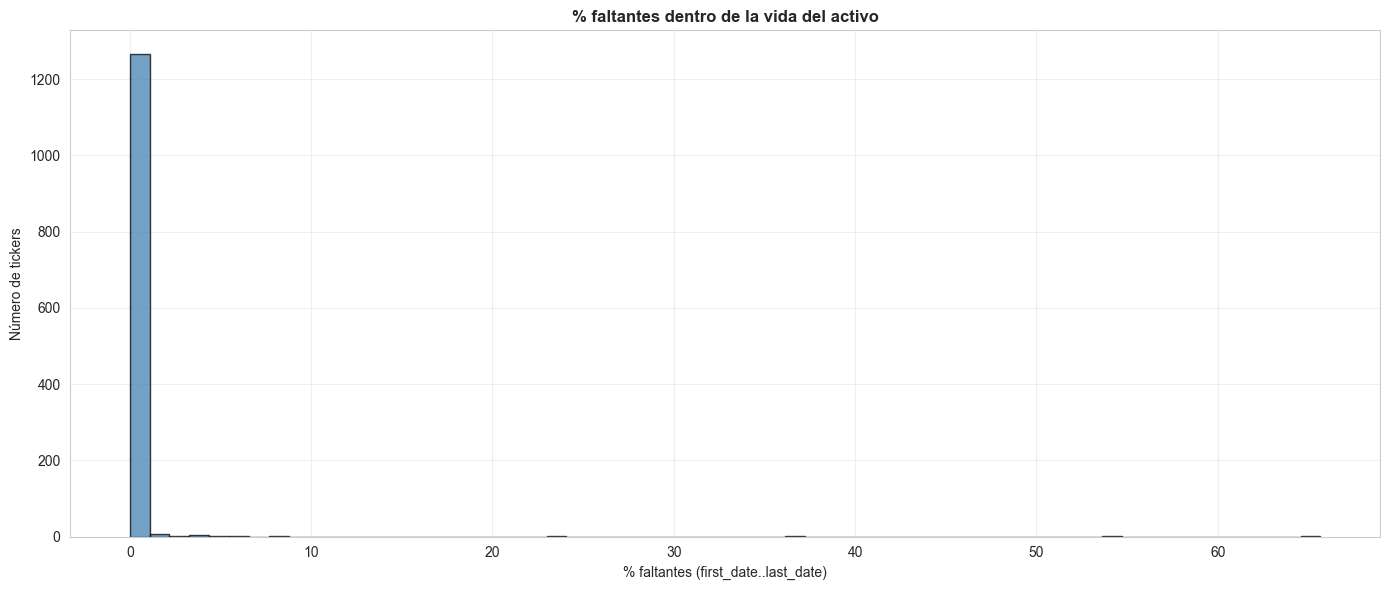

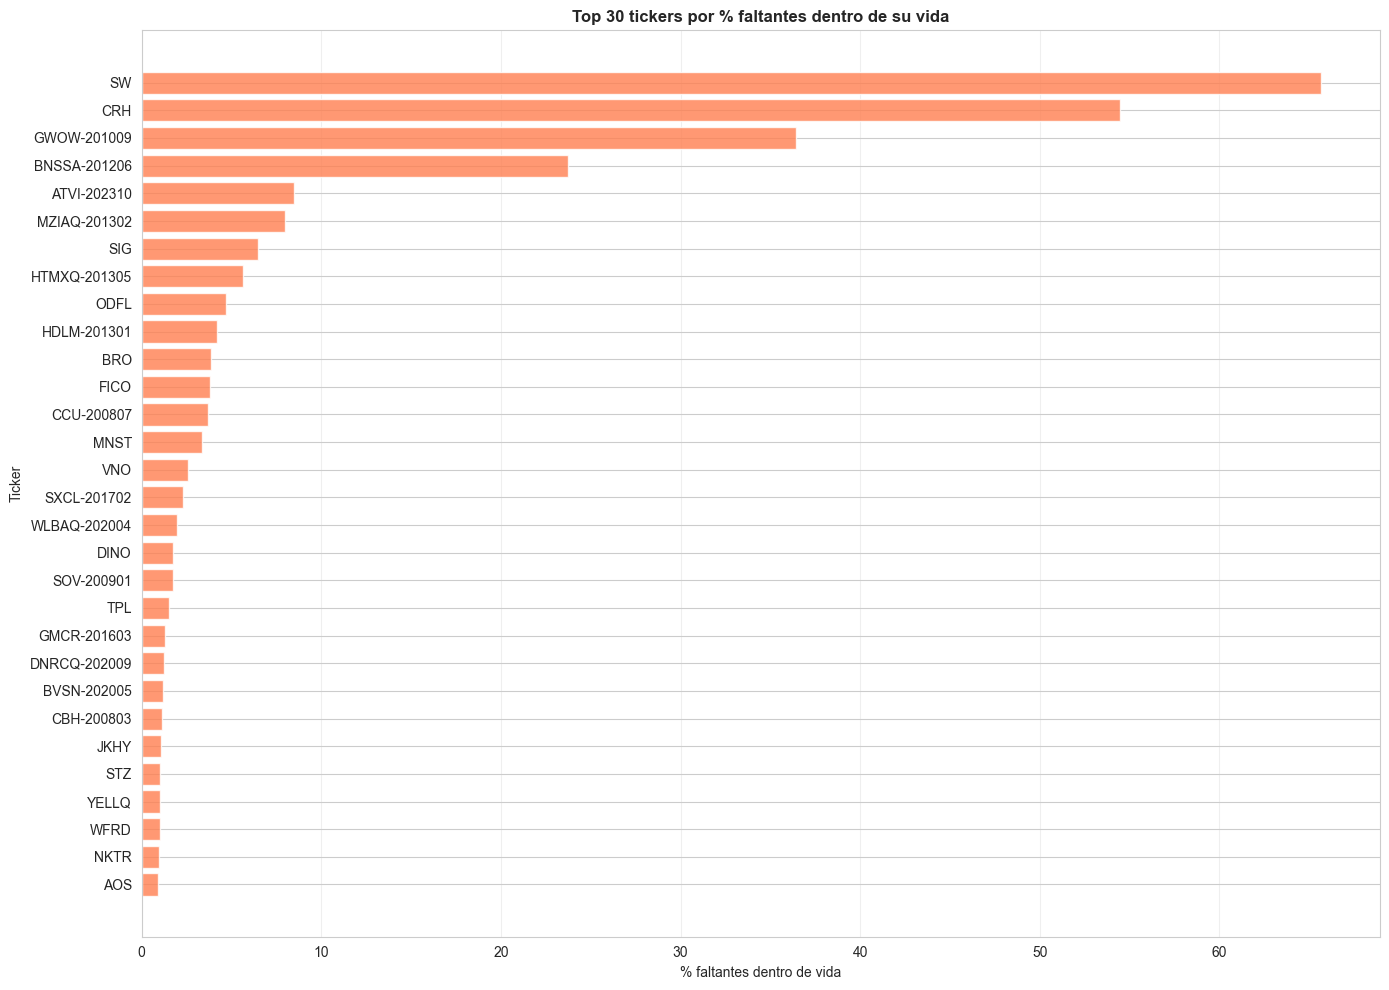

In [61]:
def compute_missing_within_life(prices: pd.DataFrame,
                               first: pd.Series,
                               last: pd.Series) -> pd.Series:
    """Compute percent missing within each asset's life.

    Parameters
    ----------
    prices : pd.DataFrame
        Wide prices with DatetimeIndex and tickers as columns.
    first : pd.Series
        First valid date per ticker.
    last : pd.Series
        Last valid date per ticker.

    Returns
    -------
    pd.Series
        Percent missing within life per ticker.
    """
    pct_missing = pd.Series(index=prices.columns, dtype='float64')

    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)

        if pd.isna(f) or pd.isna(l):
            pct_missing.loc[ticker] = np.nan
            continue

        life_slice = prices.loc[f:l, ticker]
        if len(life_slice) == 0:
            pct_missing.loc[ticker] = np.nan
            continue

        pct_missing.loc[ticker] = life_slice.isna().mean() * 100.0

    return pct_missing


pct_missing_within_life = compute_missing_within_life(
    prices=prices_wide,
    first=dates_df['first_date'],
    last=dates_df['last_date']
)

dates_df['pct_missing_within_life'] = pct_missing_within_life

print('Calidad (dentro de vida):')
print(dates_df['pct_missing_within_life'].describe(percentiles=[0.5, 0.75, 0.9, 0.95]))

# Visualización: Histograma
valid_pct = dates_df['pct_missing_within_life'].dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(valid_pct, bins=60, color='steelblue', alpha=0.75, edgecolor='black')
ax.set_title('% faltantes dentro de la vida del activo', fontweight='bold')
ax.set_xlabel('% faltantes (first_date..last_date)')
ax.set_ylabel('Número de tickers')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualización: Top 30 por % faltantes dentro de vida
top30 = dates_df['pct_missing_within_life'].sort_values(ascending=False).head(30)

fig, ax = plt.subplots(figsize=(14, 10))
ax.barh(top30.index[::-1], top30.values[::-1], color='coral', alpha=0.8)
ax.set_title('Top 30 tickers por % faltantes dentro de su vida',
             fontweight='bold')
ax.set_xlabel('% faltantes dentro de vida')
ax.set_ylabel('Ticker')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Fase 3: Delistings y fin de vida

Se usa `last_date` para diagnosticar posibles delistings: tickers cuyo último dato válido ocurre mucho antes del fin del dataset.

Tickers marcados como delisted (heurística): 638


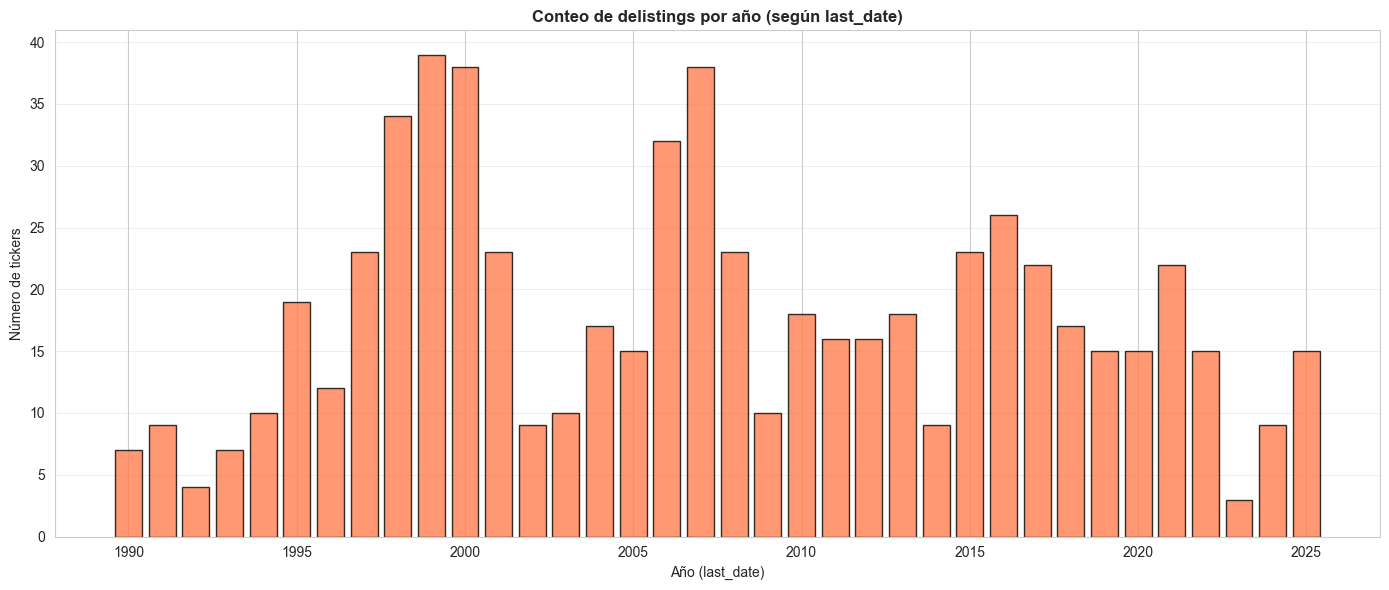


Ejemplos (top por días hasta fin del dataset):
            first_date  last_date  days_to_end  delisted
symbol                                                  
HIA-199002  1990-01-02 1990-02-07        13141      True
GNN-199006  1990-01-02 1990-06-25        13003      True
NRT-199008  1990-01-02 1990-08-08        12959      True
GRL-199008  1990-01-02 1990-08-22        12945      True
PHL-199008  1990-01-02 1990-08-22        12945      True
SOV-199008  1990-01-02 1990-08-31        12936      True
CBL-199010  1990-01-02 1990-10-08        12898      True
MCA-199101  1990-01-02 1991-01-03        12811      True
SQD-199105  1990-01-02 1991-05-28        12666      True
TKA-199108  1990-01-02 1991-08-02        12600      True
NCR-199109  1990-01-02 1991-09-19        12552      True
PN-199109   1990-01-02 1991-09-25        12546      True
CTCO-199110 1990-01-02 1991-10-31        12510      True
HBJ-199111  1990-01-02 1991-11-25        12485      True
MHC-199112  1990-01-02 1991-12-31       

In [62]:
def identify_delistings(last: pd.Series,
                       dataset_end: pd.Timestamp,
                       min_days_to_end: int = 30) -> pd.DataFrame:
    """Identify possible delistings based on last valid date.

    Parameters
    ----------
    last : pd.Series
        Last valid date per ticker.
    dataset_end : pd.Timestamp
        End date of the dataset.
    min_days_to_end : int
        Minimum calendar days between last_date and dataset_end.

    Returns
    -------
    pd.DataFrame
        Table with delisting diagnostics.
    """
    df = pd.DataFrame({'last_date': last}).copy()
    df['days_to_end'] = (dataset_end - df['last_date']).dt.days
    df['delisted'] = df['days_to_end'] >= min_days_to_end
    df.loc[df['last_date'].isna(), 'delisted'] = False

    return df


delisting_diag = identify_delistings(
    last=dates_df['last_date'],
    dataset_end=data_end,
    min_days_to_end=30
)

dates_df['days_to_end'] = delisting_diag['days_to_end']
dates_df['delisted'] = delisting_diag['delisted']

n_delisted = int(dates_df['delisted'].sum())
print(f'Tickers marcados como delisted (heurística): {n_delisted}')

# Visualización: conteo por año
if n_delisted > 0:
    delisted_last = dates_df.loc[dates_df['delisted'], 'last_date'].dropna()
    delist_by_year = delisted_last.dt.year.value_counts().sort_index()

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(delist_by_year.index, delist_by_year.values,
           color='coral', alpha=0.8, edgecolor='black')
    ax.set_title('Conteo de delistings por año (según last_date)',
                 fontweight='bold')
    ax.set_xlabel('Año (last_date)')
    ax.set_ylabel('Número de tickers')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# Tabla de ejemplos
examples = dates_df[
    dates_df['last_date'].notna()
].sort_values('days_to_end', ascending=False).head(15)

print('\nEjemplos (top por días hasta fin del dataset):')
print(examples[['first_date', 'last_date', 'days_to_end', 'delisted']])

## Fase 4: Construcción de elegibilidad para momentum (núcleo)

La elegibilidad se define por fecha de rebalanceo mensual.

Un ticker es elegible en el rebalanceo $t$ si existen precios mensuales suficientes para calcular:

- $R_{12} = \ln(P_{t-1} / P_{t-13})$
- $R_{6} = \ln(P_{t-1} / P_{t-7})$

Sin usar forward-fill para "inventar" historia completa.

Construyendo retornos y calendario de rebalanceo...
  Precios mensuales: (433, 1289)
  Rebalanceos: 133 meses

Elegibilidad: 651-767 tickers por mes


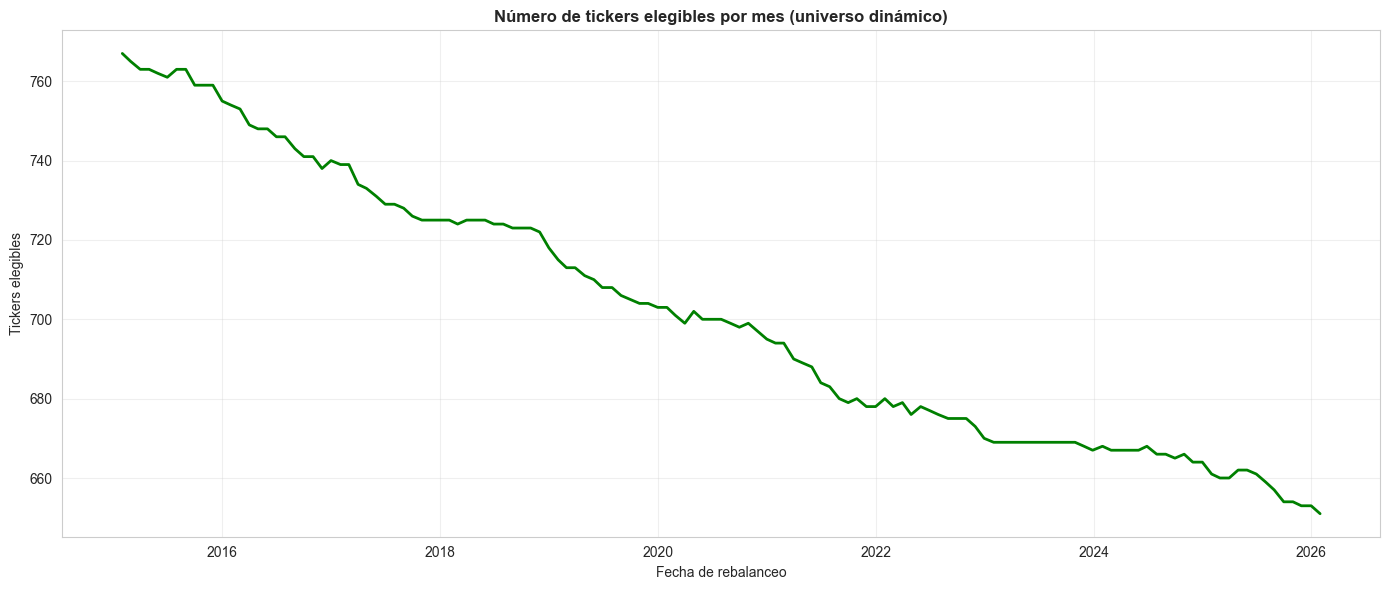

Tickers elegibles alguna vez: 832


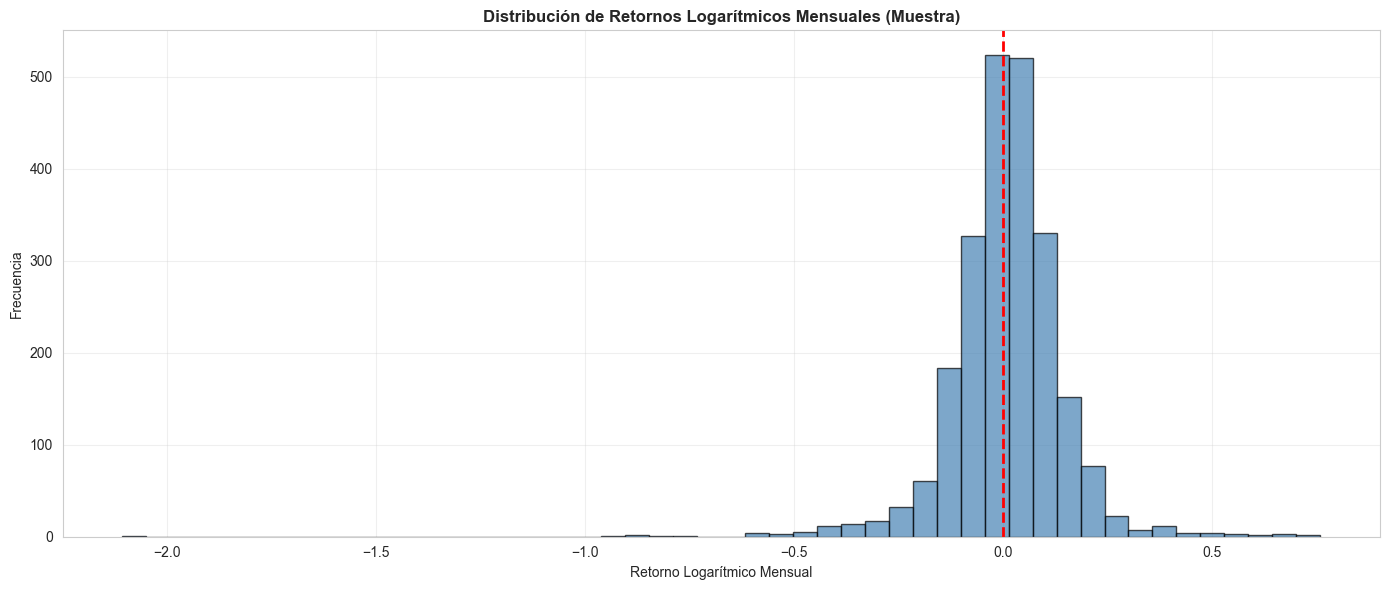

In [63]:
def calculate_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """Compute log returns from prices (daily or monthly).

    Parameters
    ----------
    prices : pd.DataFrame
        Prices (daily or monthly).

    Returns
    -------
    pd.DataFrame
        Log returns.
    """
    log_returns = np.log(prices / prices.shift(1))
    log_returns = log_returns.replace([np.inf, -np.inf], np.nan)
    return log_returns


def build_monthly_prices(prices: pd.DataFrame) -> pd.DataFrame:
    """Build business-month-end prices.

    Parameters
    ----------
    prices : pd.DataFrame
        Daily prices.

    Returns
    -------
    pd.DataFrame
        Monthly prices sampled at business month end.
    """
    return prices.resample('BME').last()


def build_rebalance_calendar(monthly_prices: pd.DataFrame,
                             start_date: pd.Timestamp) -> pd.DatetimeIndex:
    """Monthly rebalance dates: business month end >= start_date."""
    return monthly_prices.index[monthly_prices.index >= start_date]


def build_eligibility_mask(monthly_prices: pd.DataFrame,
                           rebalance_dates: pd.DatetimeIndex,
                           min_months_history: int = 13,
                           lag_months: int = 1) -> pd.DataFrame:
    """Eligibility mask for momentum windows on rebalance dates.

    Eligibility at date t requires availability of month-end prices at:
    - t-lag, t-lag-6, t-lag-12

    Parameters
    ----------
    monthly_prices : pd.DataFrame
        Business-month-end prices.
    rebalance_dates : pd.DatetimeIndex
        Rebalance dates (subset of monthly_prices.index).
    min_months_history : int
        Months needed for 12M momentum with lag=1 (typically 13).
    lag_months : int
        Lag in months (typically 1).

    Returns
    -------
    pd.DataFrame
        Boolean mask indexed by rebalance_dates, columns tickers.
    """
    eligibility = pd.DataFrame(False, index=rebalance_dates,
                              columns=monthly_prices.columns)
    min_pos = min_months_history + lag_months - 1

    for date in rebalance_dates:
        pos = monthly_prices.index.get_loc(date)
        if pos < min_pos:
            continue

        p_t1 = monthly_prices.iloc[pos - lag_months]
        p_t7 = monthly_prices.iloc[pos - (lag_months + 6)]
        p_t13 = monthly_prices.iloc[pos - (lag_months + 12)]

        elig = (p_t1.notna() & p_t7.notna() & p_t13.notna() &
                (p_t1 > 0) & (p_t7 > 0) & (p_t13 > 0))
        eligibility.loc[date] = elig

    return eligibility


print('Construyendo retornos y calendario de rebalanceo...')
log_returns_daily = calculate_log_returns(prices_close_wide)

prices_monthly_close = build_monthly_prices(prices_close_wide)
prices_monthly_open = build_monthly_prices(prices_open_wide)
rebalance_dates = build_rebalance_calendar(prices_monthly_close, backtest_start)

print(f'  Precios mensuales: {prices_monthly_close.shape}')
print(f'  Rebalanceos: {len(rebalance_dates)} meses')

prices_monthly = prices_monthly_close  # Compatibilidad

eligibility_mask = build_eligibility_mask(
    monthly_prices=prices_monthly_close,
    rebalance_dates=rebalance_dates,
    min_months_history=MIN_MONTHS_HISTORY,
    lag_months=1
)

eligible_counts = eligibility_mask.sum(axis=1)
print(f'\nElegibilidad: {int(eligible_counts.min())}-{int(eligible_counts.max())} tickers por mes')

eligible_from = pd.Series(pd.NaT, index=eligibility_mask.columns,
                         dtype='datetime64[ns]')
for ticker in eligibility_mask.columns:
    mask = eligibility_mask[ticker].to_numpy()
    if mask.any():
        eligible_from.loc[ticker] = eligibility_mask.index[int(mask.argmax())]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(eligible_counts.index, eligible_counts.values, color='green',
        linewidth=2)
ax.set_title('Número de tickers elegibles por mes (universo dinámico)',
             fontweight='bold')
ax.set_xlabel('Fecha de rebalanceo')
ax.set_ylabel('Tickers elegibles')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Tickers elegibles alguna vez: {int(eligible_from.notna().sum())}')

log_returns_monthly = calculate_log_returns(prices_monthly_close)

fig, ax = plt.subplots(figsize=(14, 6))
sample_returns = log_returns_monthly.iloc[:, :10].stack().dropna()
ax.hist(sample_returns, bins=50, color='steelblue', alpha=0.7,
        edgecolor='black')
ax.set_title('Distribución de Retornos Logarítmicos Mensuales (Muestra)',
             fontweight='bold')
ax.set_xlabel('Retorno Logarítmico Mensual')
ax.set_ylabel('Frecuencia')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Fase 5: Política de imputación (forward fill) acotada

Se aplica forward fill solo para gaps pequeños (por defecto `<= 5` días) para suavizar faltantes puntuales.

Condiciones:
- No se usa forward fill para construir elegibilidad.
- No se extiende la vida del activo: tras `last_date` se mantiene `NaN`.

Analizando gaps consecutivos...
Gaps: media=2.20, p95=7.00, max=651 días


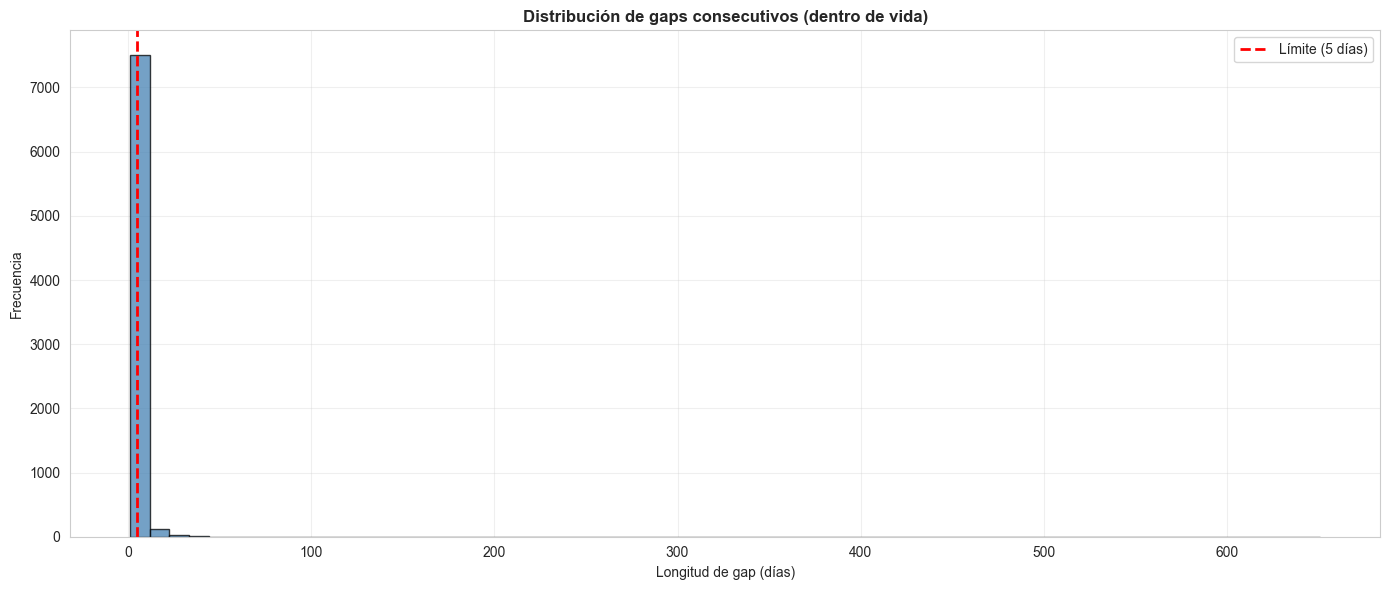


Aplicando forward fill...
CLOSE: 16,868 -> 3,692 (78.1% reducción)
OPEN: 16,868 -> 3,692 (78.1% reducción)


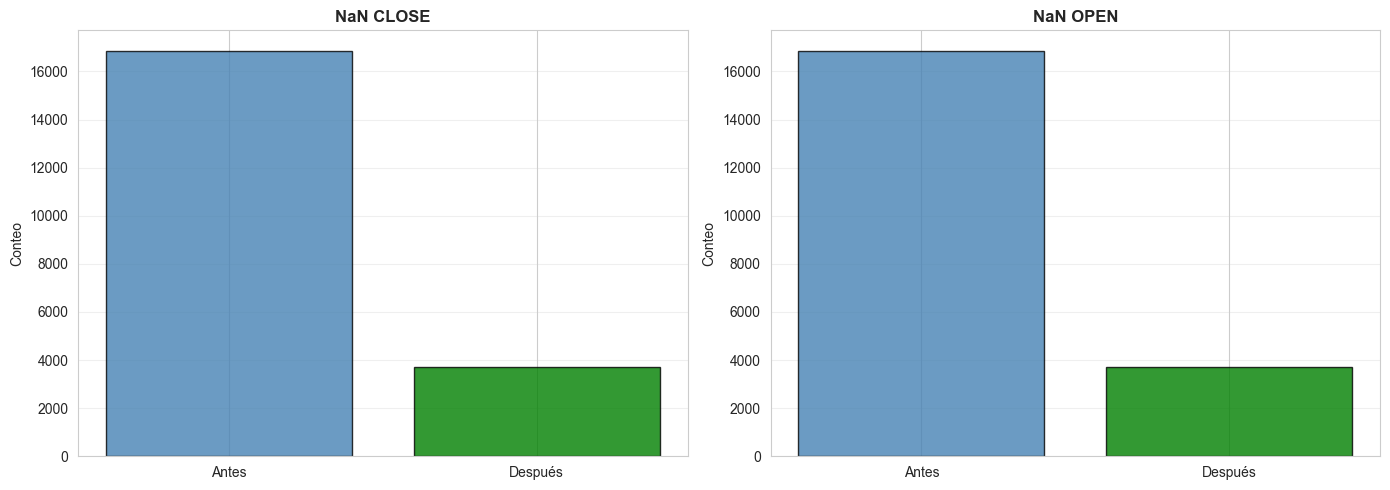

In [64]:
def forward_fill_within_life(prices: pd.DataFrame,
                             first: pd.Series,
                             last: pd.Series,
                             limit: int) -> pd.DataFrame:
    """Forward-fill only within each asset's life.

    Parameters
    ----------
    prices : pd.DataFrame
        Daily prices.
    first : pd.Series
        First valid date per ticker.
    last : pd.Series
        Last valid date per ticker.
    limit : int
        Maximum consecutive days to forward-fill.

    Returns
    -------
    pd.DataFrame
        Forward-filled prices within life.
    """
    filled = prices.copy()
    max_date = prices.index.max()

    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)
        if pd.isna(f) or pd.isna(l):
            filled[ticker] = np.nan
            continue

        filled.loc[f:l, ticker] = prices.loc[f:l, ticker].ffill(limit=limit)
        if l < max_date:
            filled.loc[prices.index > l, ticker] = np.nan

    return filled


def gap_lengths_within_life(prices: pd.DataFrame,
                            first: pd.Series,
                            last: pd.Series) -> np.ndarray:
    """Collect consecutive NaN gap lengths within each asset's life."""
    lengths = []
    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)
        if pd.isna(f) or pd.isna(l):
            continue

        s = prices.loc[f:l, ticker]
        is_na = s.isna().to_numpy()
        current = 0
        for val in is_na:
            if val:
                current += 1
            else:
                if current > 0:
                    lengths.append(current)
                    current = 0
        if current > 0:
            lengths.append(current)
    return np.array(lengths, dtype='int64')


def nan_count_within_life(prices: pd.DataFrame,
                          first: pd.Series,
                          last: pd.Series) -> int:
    """Total NaN count within life across all tickers."""
    total = 0
    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)
        if pd.isna(f) or pd.isna(l):
            continue
        total += int(prices.loc[f:l, ticker].isna().sum())
    return total


print('Analizando gaps consecutivos...')
gap_lengths = gap_lengths_within_life(prices_wide, dates_df['first_date'],
                                      dates_df['last_date'])

if len(gap_lengths) == 0:
    raise ValueError('No se pudieron calcular gaps dentro de vida.')

print(f'Gaps: media={gap_lengths.mean():.2f}, p95={np.percentile(gap_lengths, 95):.2f}, max={gap_lengths.max()} días')

fig, ax = plt.subplots(figsize=(14, 6))
bins = int(min(60, gap_lengths.max()))
ax.hist(gap_lengths, bins=bins, color='steelblue', alpha=0.75,
        edgecolor='black')
ax.axvline(FFILL_GAP_LIMIT_DAYS, color='red', linestyle='--', linewidth=2,
           label=f'Límite ({FFILL_GAP_LIMIT_DAYS} días)')
ax.set_title('Distribución de gaps consecutivos (dentro de vida)',
             fontweight='bold')
ax.set_xlabel('Longitud de gap (días)')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print('\nAplicando forward fill...')
missing_before_close = nan_count_within_life(prices_close_wide,
                                              dates_df['first_date'],
                                              dates_df['last_date'])
missing_before_open = nan_count_within_life(prices_open_wide,
                                            dates_df['first_date'],
                                            dates_df['last_date'])

prices_close_ffill = forward_fill_within_life(prices_close_wide,
                                              dates_df['first_date'],
                                              dates_df['last_date'],
                                              FFILL_GAP_LIMIT_DAYS)
prices_open_ffill = forward_fill_within_life(prices_open_wide,
                                             dates_df['first_date'],
                                             dates_df['last_date'],
                                             FFILL_GAP_LIMIT_DAYS)

missing_after_close = nan_count_within_life(prices_close_ffill,
                                            dates_df['first_date'],
                                            dates_df['last_date'])
missing_after_open = nan_count_within_life(prices_open_ffill,
                                          dates_df['first_date'],
                                          dates_df['last_date'])

reduction_close_pct = ((missing_before_close - missing_after_close) /
                       missing_before_close * 100) if missing_before_close > 0 else 0
reduction_open_pct = ((missing_before_open - missing_after_open) /
                      missing_before_open * 100) if missing_before_open > 0 else 0

print(f'CLOSE: {missing_before_close:,} -> {missing_after_close:,} '
      f'({reduction_close_pct:.1f}% reducción)')
print(f'OPEN: {missing_before_open:,} -> {missing_after_open:,} '
      f'({reduction_open_pct:.1f}% reducción)')

prices_ffill = prices_close_ffill  # Compatibilidad

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(['Antes', 'Después'], [missing_before_close, missing_after_close],
            color=['steelblue', 'green'], alpha=0.8, edgecolor='black')
axes[0].set_title('NaN CLOSE', fontweight='bold')
axes[0].set_ylabel('Conteo')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(['Antes', 'Después'], [missing_before_open, missing_after_open],
            color=['steelblue', 'green'], alpha=0.8, edgecolor='black')
axes[1].set_title('NaN OPEN', fontweight='bold')
axes[1].set_ylabel('Conteo')
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Procesamiento de SPY (Benchmark)

Se procesa el benchmark SPY con forward fill y se calculan retornos diarios y mensuales.

In [65]:
print('\nProcesando SPY...')
spy_required = {'open', 'close'}
if spy_required - set(spy_df.columns):
    raise ValueError(f'SPY falta columnas: {sorted(spy_required - set(spy_df.columns))}')

spy_clean = pd.DataFrame({
    'open': spy_df['open'].ffill(limit=FFILL_GAP_LIMIT_DAYS),
    'close': spy_df['close'].ffill(limit=FFILL_GAP_LIMIT_DAYS),
    'high': spy_df['high'].ffill(limit=FFILL_GAP_LIMIT_DAYS),
    'low': spy_df['low'].ffill(limit=FFILL_GAP_LIMIT_DAYS)
}, index=spy_df.index)

spy_clean = spy_clean.loc[spy_clean.index >= history_start].copy()

spy_log_returns_daily = calculate_log_returns(spy_clean[['close']])
spy_log_returns_daily.columns = ['SPY']

spy_prices_monthly = build_monthly_prices(spy_clean[['close']])
spy_prices_monthly.columns = ['SPY']
spy_log_returns_monthly = calculate_log_returns(spy_prices_monthly)
spy_log_returns_monthly.columns = ['SPY']

missing_spy = spy_prices_monthly.reindex(rebalance_dates)['SPY'].isna().sum()
print(f'SPY: {spy_clean.shape[0]} días, {spy_prices_monthly.shape[0]} meses, '
      f'{missing_spy} faltantes en rebalanceo')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
axes[0].plot(spy_clean.index, spy_clean['close'], color='green', linewidth=1.5)
axes[0].set_title('Evolución de Precio SPY (Diario)', fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Precio Cierre ($)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(spy_log_returns_monthly.index, spy_log_returns_monthly['SPY'],
             color='darkgreen', linewidth=1.5, marker='o', markersize=3)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Retornos Logarítmicos Mensuales SPY', fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Retorno Logarítmico Mensual')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Procesando SPY...


TypeError: Invalid comparison between dtype=datetime64[ns, America/New_York] and Timestamp

## Fase 6: Dataset final + metadata

Se construye el dataset final sin eliminar tickers por no existir desde `history_start`.

Se guarda:
- Precios diarios limpios (desde `history_start`)
- Retornos logarítmicos diarios
- Metadata por ticker (incluye `eligible_from`)
- Máscara de elegibilidad mensual (recomendado para Notebook 3)

In [ ]:
print('Construyendo dataset final...')
prices_close_final = prices_close_ffill.loc[prices_close_ffill.index >= history_start].copy()
prices_open_final = prices_open_ffill.loc[prices_open_ffill.index >= history_start].copy()
log_returns_final = calculate_log_returns(prices_close_final)
prices_final = prices_close_final  # Compatibilidad

metadata = pd.DataFrame({
    'first_date': dates_df['first_date'],
    'last_date': dates_df['last_date'],
    'delisted': dates_df['delisted'].fillna(False),
    'pct_missing_within_life': dates_df['pct_missing_within_life'],
    'eligible_from': eligible_from,
    'ever_eligible': eligible_from.notna(),
    'reason_excluded': None
})

quality_threshold = 90.0
exclude_mask = (~metadata['ever_eligible'] &
                (metadata['pct_missing_within_life'] > quality_threshold))
metadata.loc[exclude_mask, 'reason_excluded'] = (
    f'Calidad muy baja (> {quality_threshold}% faltantes) y nunca elegible'
)

print(f'Metadata: {len(metadata)} tickers, {metadata["ever_eligible"].sum()} elegibles, '
      f'{metadata["delisted"].sum()} delisted')

print('\nValidaciones finales...')
checks = [
    ('OPEN en rebalanceo', prices_open_final.reindex(rebalance_dates).isna().sum().sum() == 0),
    ('CLOSE en rebalanceo', prices_close_final.reindex(rebalance_dates).isna().sum().sum() == 0),
    ('SPY en rebalanceo', spy_prices_monthly.reindex(rebalance_dates)['SPY'].isna().sum() == 0),
    ('Sin infinitos diarios', np.isinf(log_returns_final).sum().sum() == 0),
    ('Sin infinitos mensuales', np.isinf(log_returns_monthly).sum().sum() == 0),
    ('Precios positivos', ((prices_close_final < 0).sum().sum() == 0 and
                           (prices_open_final < 0).sum().sum() == 0))
]

for name, ok in checks:
    print(f'  {name}: {"OK" if ok else "ERROR"}')

print('\nGuardando archivos...')

files = [
    ('clean_data.parquet', prices_close_final, 'Notebook 3, 4'),
    ('prices_open_daily.parquet', prices_open_final, 'Notebook 4'),
    ('log_returns.parquet', log_returns_final, 'Notebook 3, 4'),
    ('prices_monthly.parquet', prices_monthly_close, 'Notebook 3'),
    ('prices_open_monthly.parquet', prices_monthly_open, 'Notebook 4'),
    ('log_returns_monthly.parquet', log_returns_monthly, 'Notebook 3'),
    ('ticker_metadata.csv', metadata, 'Notebook 3, 4, 5'),
    ('eligibility_mask.parquet', eligibility_mask, 'Notebook 3'),
    ('rebalance_dates.csv', pd.Series(rebalance_dates, name='rebalance_date'), 'Notebook 3, 4'),
    ('spy_clean.parquet', spy_clean, 'Notebook 5'),
    ('spy_log_returns_daily.parquet', spy_log_returns_daily, 'Notebook 5'),
    ('spy_prices_monthly.parquet', spy_prices_monthly, 'Notebook 5'),
    ('spy_log_returns_monthly.parquet', spy_log_returns_monthly, 'Notebook 5')
]

for filename, data, used_in in files:
    path = f'{DATA_PROCESSED_DIR}/{filename}'
    if filename.endswith('.csv'):
        data.to_csv(path)
    else:
        data.to_parquet(path, engine='pyarrow')
    print(f'  {filename}')

# Aliases (solo documentar, no guardar duplicados)
aliases = [
    ('prices_close_daily.parquet', 'clean_data.parquet'),
    ('prices_close_monthly.parquet', 'prices_monthly.parquet')
]
print('\nAliases (no guardados, usar archivos principales):')
for alias, main_file in aliases:
    print(f'  {alias} -> {main_file}')

print(f'\nResumen: {len(metadata)} tickers, {metadata["ever_eligible"].sum()} elegibles, '
      f'{len(rebalance_dates)} rebalanceos, {len(files)} archivos guardados')
print('Notebook 2 completado exitosamente.')

Construyendo dataset final...
  prices_final shape: (3059, 1289)
  rango: 2013-12-02 a 2026-01-30
  log_returns_final shape: (3059, 1289)

Metadata:
  total tickers: 1289
  ever_eligible: 832
  delisted: 638
  excluded: 0

Resumen de elegibilidad:
count                              832
mean     2015-05-27 06:39:48.461538304
min                2015-01-30 00:00:00
25%                2015-01-30 00:00:00
50%                2015-01-30 00:00:00
75%                2015-01-30 00:00:00
max                2025-10-31 00:00:00
Name: eligible_from, dtype: object

Validaciones finales:
  Sin infinitos en retornos: OK (detalle: 0)
  Precios positivos: OK (detalle: 0)
  Elegibilidad crece (late entrants): ERROR

Guardado: ..\datos\processed\clean_data.parquet
Guardado: ..\datos\processed\log_returns.parquet
Guardado: ..\datos\processed\ticker_metadata.csv
Guardado: ..\datos\processed\eligibility_mask.parquet
Guardado: ..\datos\processed\rebalance_dates.csv

Resumen ejecutivo:
  Tickers totales: 1289
 